In [1]:
%cd ../

/Users/tahaismail/Desktop/work/Baylor_Hayden/PreyPursuit


In [2]:
# load modules
import os
from legacy.controllers import utils as ut
from pathlib import Path
from sklearn.decomposition import PCA
import legacy.ChangeOfMind.functions.processing as proc
from legacy.PacTimeOrig.data import scripts
from scipy.io import loadmat
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from legacy.PacTimeOrig.data import scripts

/Users/tahaismail/miniforge3/envs/pac_control_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set paths
subj = 'YFD'
results_path = os.path.join('example_data', subj)
data_dir = os.path.join('example_data' , subj)
model = 'pv'

In [4]:
# create paths
results_path = Path(results_path)
model_output_path = results_path / model
model_output_path.mkdir(parents=True, exist_ok=True)

In [5]:
# generate config
# set optimization parameters
cfgparams=ut.generate_sim_defaults()

# add cfgparams
trialtype='2'
cfgparams['data_path'] = os.path.dirname(data_dir)
cfgparams['scaling'] = 0.001
cfgparams['subjtype']='emu'
cfgparams['folder'] = os.path.dirname(data_dir)
cfgparams['subj'] = subj
#cfgparams['wtype'] = 'bma'
cfgparams['trialtype']=trialtype

In [6]:
Xdsgn, kinematics, sessvars, psth, brainareas = scripts.human_emu_run(cfgparams) # no need for psth right now 

In [7]:
# load modeling results
df = pd.read_csv(results_path / model / 'model_fit_results.csv', index_col=0)
output_mats = loadmat(results_path / model / 'model_matrices.mat')['pt_outs']

In [8]:
# add cfgparams
#sess = 1
prewin = 14 #14
behavewin=15
#cfgparams['session'] = sess
cfgparams['event'] = 'zero' 
cfgparams['dropwin'] = 20
if cfgparams['event'] == 'zero':
    cfgparams['prewin'] = prewin
    cfgparams['behavewin'] = behavewin  # needs to be less than or equal to cfg.dropwin;
elif cfgparams['event'] == 'onset':
    cfgparams['prewin'] = 17
    cfgparams['behavewin'] = 8  # needs to be less than or equal to cfg.dropwin;

cfgparams['winafter'] = cfgparams['behavewin'] + 3

cfgparams['template1_thresh'] = 0.99
cfgparams['template2_thresh'] = 0.7
cfgparams['template1_sub_thresh'] = 0.97
cfgparams['folder'] = results_path
cfgparams['keepamount'] = 40
#cfgparams['timewarp'] = {}
#cfgparams['timewarp']['dowarp'] = False
#cfgparams['timewarp']['warpN'] = cfgparams['prewin'] + cfgparams['behavewin'] + 1
#cfgparams['timewarp']['originalTimes'] = np.arange(1, cfgparams['timewarp']['warpN'] + 1)
cfgparams['percent_train'] = 0.9
cfgparams['startidx'] = 4
cfgparams['endidx'] = 5
cfgparams['trialidx'] = 6
cfgparams['directidx'] = 2

In [9]:
# get wt matrix
trialnum = sessvars.trialidx.values # get 2 prey trials number
vdiff = np.abs(np.diff(np.array([[df.loc[0, 'val1'], df.loc[0, 'val2']] for df in Xdsgn]),axis=1)) # extract reward difference

# — round any “1”→2 and “3”→4 so that vdiff only takes on {0,2,4}
vdiff = vdiff.flatten()
vdiff[vdiff == 1] = 2
vdiff[vdiff == 3] = 4
vdiff = vdiff.reshape(-1,1)

cfg = cfgparams
# wt = [mat['model_shift'][0].reshape(-1, 1) for mat in output_mats]

# If loading the data instead of re-running the modelling here
wt = [mat['model_shift'][0, 0][0].reshape(-1, 1) for mat in output_mats.squeeze()] # just re-organize wt

#wt = [wt[i] for i in range(len(wt)) if i not in rmtrial]

isgood = proc._wt_check(wt) #this flags with zero trials in which shifts are too fast and cannot be analyzed 
zcrossidx = proc._get_zero_cross(cfg,wt) # extract indices for which there was a valid cross of 0.5 and remove any crossing that happened within 150ms from the beginning of the trial 
tmpzcrosscheck, timebetweenzcross = proc._zcrossingcheck(zcrossidx, wt)
tmpzcrosscheck = list(tmpzcrosscheck.values())
timebetweenzcross = list(timebetweenzcross.values())


In [10]:
#remove trials that cannot be analyzed because of too fast shifts (bad ones)
indices_to_remove = np.where(isgood == 0)[0]
wt = [item for idx, item in enumerate(wt) if idx not in indices_to_remove]
zcrossidx = [item for idx, item in enumerate(zcrossidx) if idx not in indices_to_remove]
tmpzcrosscheck = [item for idx, item in enumerate(tmpzcrosscheck) if idx not in indices_to_remove]
timebetweenzcross = [item for idx, item in enumerate(timebetweenzcross) if idx not in indices_to_remove]
trialnum = np.delete(trialnum, indices_to_remove)
vdiff = np.delete(vdiff, indices_to_remove)

In [11]:
# filter crossings too close to endpoint
#get length of all trials and then check that adding the behavewin we do not go over the trial length 
lengths = [len(df) for df in wt]
for i in range(len(zcrossidx)):
    zcrossidx[i] = zcrossidx[i][(zcrossidx[i] + cfg['behavewin'] + 1) <= lengths[i]]

#Filter out those with whack timing (switch too close to the end) 
zcrossidx = [proc._filter_by_difference(arr) for arr in zcrossidx]

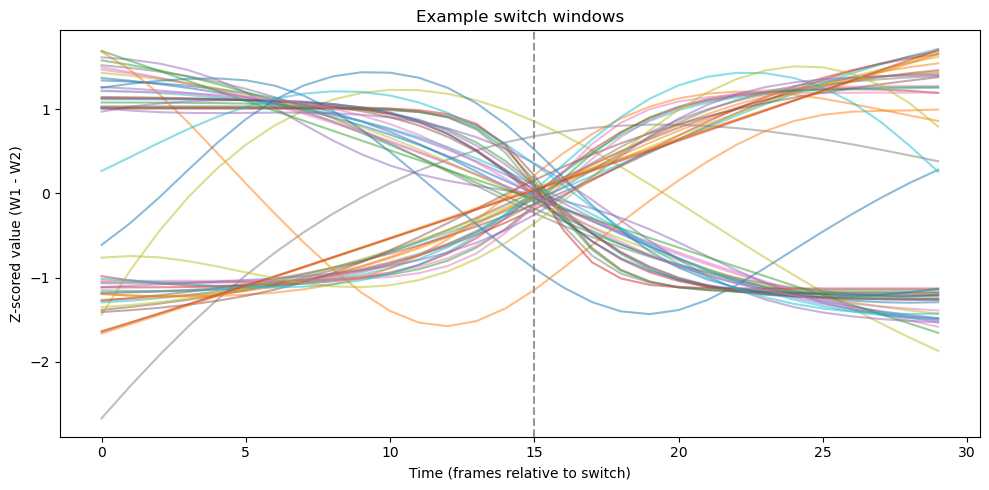

In [12]:
# Split them into windows and stack them
import matplotlib.pyplot as plt

wtsplit = []
iteration=1
for trial in range(len(wt)):
    for j in range(len(zcrossidx[trial])):
        start=[zcrossidx[trial][j]-cfg['behavewin']]
        end=[zcrossidx[trial][j]+cfg['behavewin']]
        wtsplit.append((np.hstack([wt[trial][start[0]:end[0]].flatten(), trial, trialnum[trial],j])).reshape(-1,1)) #this is in 3D
        iteration=iteration+1

wtsplit = np.hstack(wtsplit).transpose() # end up with a matrix number of switches x samples (samples = 2*behavewin +3, 3 are metadata)
# metadata here are: switch number in the wtsplit matrix = trial in the loop (zero based), real trial number (non zero based), switch number within a trial

wttmpcorr=(wtsplit[:,0:-3]-np.mean(wtsplit[:,0:-3],axis=1,keepdims=True))/np.std(wtsplit[:,0:-3],axis=1,keepdims=True)

plt.figure(figsize=(10,5))
for i in range(50):
    plt.plot(wttmpcorr[i], alpha=0.5)
plt.axvline(cfg['behavewin'], color='gray', linestyle='--', alpha=0.8)
plt.title("Example switch windows")
plt.title("Example switch windows")
plt.xlabel("Time (frames relative to switch)")
plt.ylabel("Z-scored value (W1 - W2)")
plt.tight_layout()
plt.show()



In [13]:
# apply PCA (1st time)
# find the main time‐varying patterns (components) that explain the variance across my different switch‐windows
pca=PCA(n_components=5)
score = pca.fit_transform(wtsplit[:,0:-3].transpose()) # scores now are timestamps x switches/PC to retain = 30 x 5 

#Get type 1 = 1st PC z-scored
template = (score[:,0]-np.mean(score[:,0]))/np.std(score[:,0])
tempmatch = np.abs(np.array([pearsonr(template, row)[0] for row in wttmpcorr])) # compute Person's corr between PC1 and each switch and take abs value
# Pearson's on z-scored data is mathematically equal to cosine similarity!! 
kp1=np.where(tempmatch>cfg['template1_thresh'])[0]

#Get type 2 = 2nd PC z-scored
template = (score[:,1]-np.mean(score[:,1]))/np.std(score[:,1])
tempmatch = np.abs(np.array([pearsonr(template, row)[0] for row in wttmpcorr]))
kp2=np.where(tempmatch>cfg['template2_thresh'])[0]

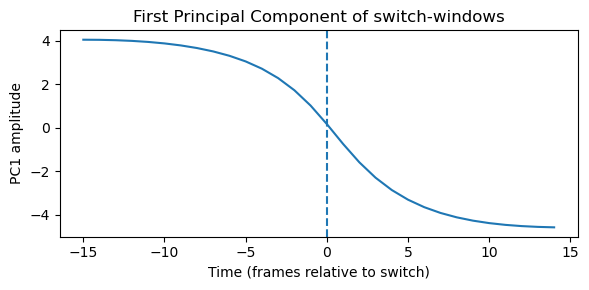

In [14]:
# visualize 1st PC to see if shape is sigmoidal 
import matplotlib.pyplot as plt
import numpy as np

# pc1 is the first principal component time‐series
pc1 = score[:, 0]

# make an x‐axis in frames relative to the switch (center at behavewin)
frames = np.arange(len(pc1)) - cfgparams['behavewin']

plt.figure(figsize=(6,3))
plt.plot(frames, pc1)
plt.axvline(0, linestyle='--')               # switch moment at frame 0
plt.xlabel('Time (frames relative to switch)')
plt.ylabel('PC1 amplitude')
plt.title('First Principal Component of switch‐windows')
plt.tight_layout()
plt.show()

In [15]:
# assign type to switches 
length_wtsplit = len(wtsplit)
splittypes = np.zeros((length_wtsplit, 2), dtype=int)  # 2D array with two columns 
splittypes[:, 0] = np.arange(0, length_wtsplit)  # First column: 0 to length(wtsplit), tracks the number of splits
splittypes[kp1, 1] = 1 # type 1 switches = full switch
splittypes[kp2, 1] = 2 # type 2 switches = partial or revers switch 
# Assign -1 to uncategorized rows
splittypes[splittypes[:, 1] == 0, 1] = -1

In [16]:
# Apply PCA (2nd time)
# Take all type 1 switches and perform PCA again 
subwt=wttmpcorr[kp1,:] # windows x type1 switches 
score = pca.fit_transform(subwt[:, 0:].transpose()) # PCA will find the dominant shape within type 1 switches 
template = (score[:, 0] - np.mean(score[:, 0])) / np.std(score[:, 0]) #take 1st PC, zscore to define a new template 

tempmatch = np.abs(np.array([pearsonr(template, row)[0] for row in subwt])) # again Pearsons's corr, but this time on the refined template 
kp3=kp1[np.where(tempmatch<cfg['template1_sub_thresh'])[0]]
splittypes[kp3, 1] = 3 # assign 3 to switches that did not pass this second template matching 

In [17]:
_, counts = np.unique(splittypes[:, 1], return_counts=True)
print("\nFinal Switch Type Counts:")
for t, c in zip([-1, 1, 2, 3], counts):
    print(f"  Type {t}: {c}")
print(len(splittypes))


Final Switch Type Counts:
  Type -1: 94
  Type 1: 63
  Type 2: 6
163


In [18]:
# Find rows where column 2 of splittypes is 1
indices = np.where(splittypes[:, 1] == 1)[0]

# Compute the mean of wtsplit for these indices, columns 1 and 2
mu = np.mean(wtsplit[indices, :2], axis=1)

# Determine high-to-low and low-to-high transitions
hilo = (mu - 0.5) > 0
lohi = (mu - 0.5) < 0

# Assign values to kp1 in column 3 of splittypes based on the conditions - so now we have a column that indicates the direction of the switch
splittypes = np.hstack((splittypes, np.zeros((len(splittypes), 1))))
splittypes[indices[hilo], 2] = 1
splittypes[indices[lohi], 2] = -1

# Convert tmpzcrosscheck and zcrossidx to NumPy arrays
zcrossidx_array = np.array(np.concatenate(zcrossidx)).T  # Transpose to match MATLAB's behavior

# Add as new columns to splittypes
splittypes = np.hstack((splittypes, zcrossidx_array.reshape(-1, 1)))
# now splittypes has 4 columns: split/switch number, switch type, direction of the switch, frame index of the switch)

switchstartidx, backward_winsize, switchendidx, forward_winsize = proc._get_start_end(wt,zcrossidx)

In [19]:
#Size check
for i in range(len(zcrossidx)):
    if zcrossidx[i].size == 0:
        zcrossidx[i]=np.array((999))

tmpz = np.hstack(zcrossidx) # all switch frames 
tmps = np.hstack(switchstartidx) # all start frames indeces
tmpe = np.hstack(switchendidx) # all end frames indeces


# where we marked “no switch” with 999, we remove that entry from all three arrays
indices_to_remove = np.where(tmpz==999)[0] 
tmpz=np.delete(tmpz,indices_to_remove)
tmps=np.delete(tmps,indices_to_remove)
tmpe=np.delete(tmpe,indices_to_remove)

tmps = tmpz - tmps
tmpe = tmpz + tmpe-cfg['behavewin']

#filter splittypes as well - otherwise in some cases tmpz and splittypes have different number of elements 
valid_switch_frames = tmpz

# Identify switches in splittypes whose frame index is *not* in valid_switch_frames
split_switch_frames = splittypes[:, 3].astype(int) # switch frame is column 4 (3 if zero indexed) of splittypes
split_mask = np.isin(split_switch_frames, valid_switch_frames) 

splittypes_filtered = splittypes[split_mask, :]
wtsplit_filtered = wtsplit[split_mask, :]

wtsplit = wtsplit_filtered
splittypes = splittypes_filtered

# add to splittypes the reward difference
splittypes = np.hstack((splittypes, tmps.reshape(-1, 1), tmpe.reshape(-1, 1), wtsplit[:, -3:]))

vd=[]
un=np.unique(splittypes[:,-3])
for i in un:
    vd.append(np.tile(vdiff[int(i)],len(np.where(splittypes[:, -3] == i)[0])))

splittypes = np.hstack((splittypes,np.hstack(vd).reshape(-1, 1)))

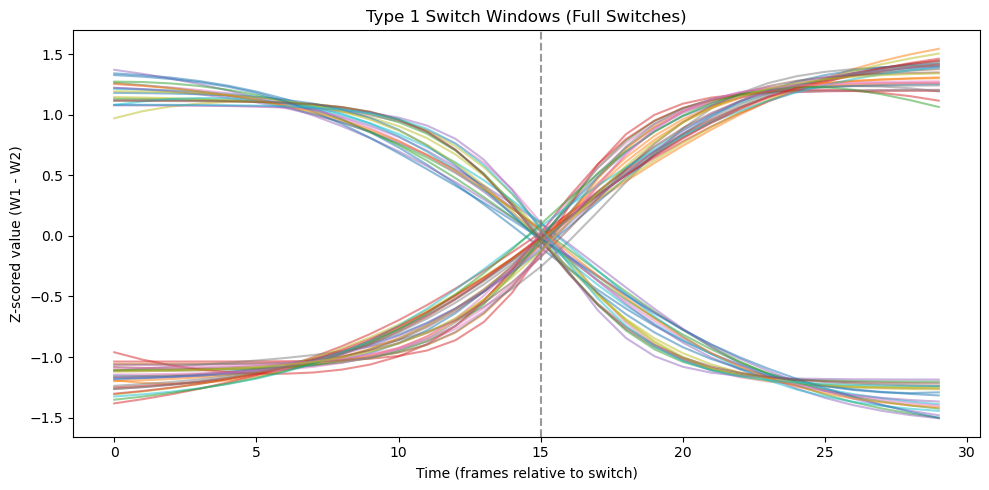

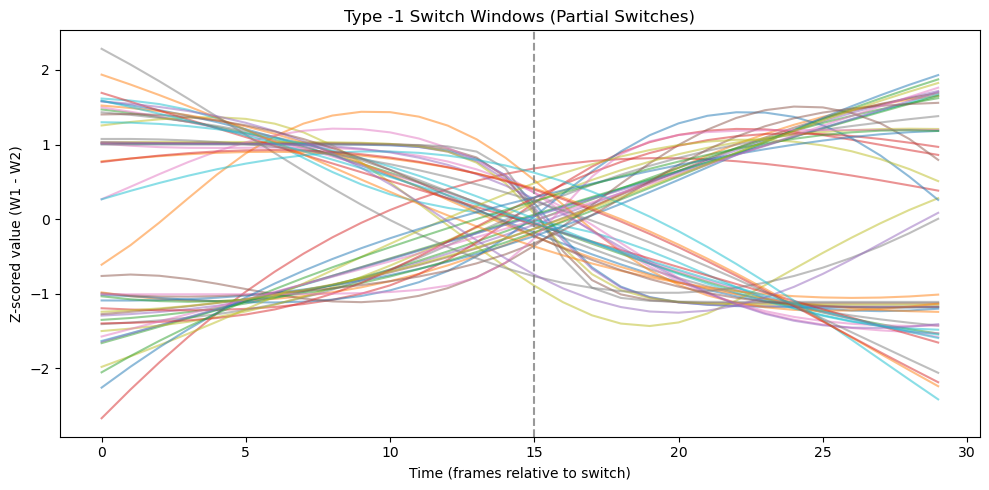

In [20]:
# Get indices of type-1 switches
type1_idx = np.where(splittypes[:, 1] == 1)[0]

# Plot a subset (e.g. first 50) of type-1 switches
plt.figure(figsize=(10, 5))
for i in range(min(50, len(type1_idx))):
    plt.plot(wttmpcorr[type1_idx[i]], alpha=0.5)
    
plt.title("Type 1 Switch Windows (Full Switches)")
plt.xlabel("Time (frames relative to switch)")
plt.ylabel("Z-scored value (W1 - W2)")
plt.axvline(cfg['behavewin'], color='gray', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

# Get indices of type -1 switches
typeno1_idx = np.where(splittypes[:, 1] == -1)[0]

# Plot a subset (e.g. first 50) of type-1 switches
plt.figure(figsize=(10, 5))
for i in range(min(50, len(typeno1_idx))):
    plt.plot(wttmpcorr[typeno1_idx[i]], alpha=0.5)
    
plt.title("Type -1 Switch Windows (Partial Switches)")
plt.xlabel("Time (frames relative to switch)")
plt.ylabel("Z-scored value (W1 - W2)")
plt.axvline(cfg['behavewin'], color='gray', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()